# Jan Izydorczyk
# Airly Data Science project

## Goal

Testing the interpolation efficiency of the *IDW* method for determining the value of the *pm10* for places where no measurements were taken.

## Implementation

For every hour valid measurements will be splitted into testing and "training" sets.

Then, an error of interpolation will be calculated for the data from the test set using the training one.

The error from single hour test is defined as average relative distance from correct values, which gives the formula:
$$
E_k = \sum_{i=1}^{n_k}|\frac{w_i-e_i}{w_i}|
$$
where $E_k$ is *k*th test hour error, $w_i$ is measured value from testing set and $e_i$ is interpolated value.

The finall metric, which will be minimalised, will be the median of set of errors ${E_k : k \in {1, 2, ..., N}}$

## Imports

In [2]:
import numpy as np
rng = np.random.default_rng()
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
from geopy.distance import distance
geo_dist= lambda a,b: distance(a, b).km
from scipy.spatial.distance import cdist
from sklearn.model_selection import ShuffleSplit
from mpmath import mpf, nstr

In [6]:
0 * np.nan

nan

## Dataset
Dataset is storred locally, for convinience.

In [2]:
months = [
    'january',
    'february',
    'march',
    'april',
    'may',
    'june',
    'july',
    'august',
    'september',
    'october',
    'november',
    'december'
]

data = []

for month in months:
    data.append(pd.read_csv(f'data/{month}-2017.csv'))
data = pd.concat(data)
data = data.filter(regex='pm10', axis=1).to_numpy()

Sensors are sorted in asscendig order relative to their ID, there is no purpose for storing it.

In [3]:
sensors = pd.read_csv('data/sensor_locations.csv')
sensors = sensors.to_numpy()[:, [1, 2]]

## IDW implementation

Code is written using only highly optimised NumPy functions.

In [4]:
def idw_point(inv_p_dist_mat, p_idx, ps_ids, weights, p):
    W = inv_p_dist_mat[p_idx, ps_ids]
    A = np.dot(weights, W)
    B = np.sum(W)
    return A / B

In [64]:
def test_idw_for_set(inv_p_dist_mat, points, weights, p=2):
    proper = ~( np.isnan(weights) | (weights == 0))
    points = points[proper]
    weights = weights[proper]
    ss = ShuffleSplit(n_splits=1, test_size=0.25)
    train, test = next(ss.split(np.arange(points.shape[0])))
    idw = lambda p_idx: idw_point(inv_p_dist_mat, p_idx, ps_ids = train, weights=weights[train], p=p)
    res = np.apply_along_axis(idw, 1, test[:, np.newaxis])
    return np.mean(np.abs((res - weights[test]) / weights[test] ))
    

In [6]:
def make_dist_mat(points, metric=geo_dist):
    dist_mat = cdist(points, points, metric=metric)
    np.fill_diagonal(dist_mat, 1)
    return dist_mat

In [30]:
def test_idw_whole(data, points, p=2, dist_mat=None, perc=1):
    from random import sample
    if dist_mat is None:
        dist_mat = make_dist_mat(points, geo_dist)
    inv_p_dist_mat = 1 / dist_mat ** p
    chosen = sample(range(data.shape[0]), int(data.shape[0] * perc))
    data = data[chosen]
    idw = lambda weights: test_idw_for_set(inv_p_dist_mat=inv_p_dist_mat, points=points, weights=weights, p=p)
    return np.apply_along_axis(idw, 1, data)

Distance between all pair of the sensors is cached in **distance_matrix**, for optimalization reasons.  

In [24]:
dist_mat = make_dist_mat(sensors, geo_dist)

In [90]:
%matplotlib notebook

In [99]:
ps1 = np.linspace(1.5, 2.6, 40).reshape(-1, 1)
medians1 = np.apply_along_axis(lambda p: np.median(test_idw_whole(data, sensors, p=p, dist_mat=dist_mat, perc=0.5)), 1, ps1)

In [100]:
ps2 = np.linspace(0.7, 1.5, 40).reshape(-1, 1)
medians2 = np.apply_along_axis(lambda p: np.median(test_idw_whole(data, sensors, p=p, dist_mat=dist_mat, perc=0.5)), 1, ps2)

In [101]:
ps3 = np.linspace(0.1, 0.7, 40).reshape(-1, 1)
medians3 = np.apply_along_axis(lambda p: np.median(test_idw_whole(data, sensors, p=p, dist_mat=dist_mat, perc=0.5)), 1, ps3)

<IPython.core.display.Javascript object>


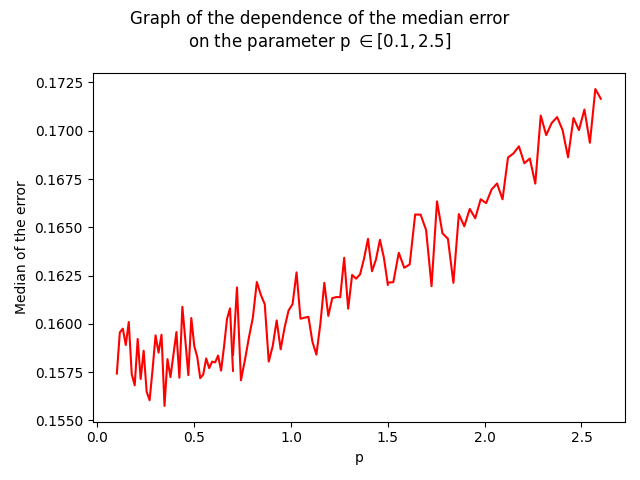

In [106]:
fig = plt.figure()
plt.plot(ps1, medians1, color='red')
plt.plot(ps2, medians2, color='red')
plt.plot(ps3, medians3, color='red')

fig.suptitle('Graph of the dependence of the median error\non the parameter p $\in[0.1, 2.5]$')
plt.xlabel('p')
plt.ylabel('Median of the error')
fig.tight_layout()
plt.show()

After simple analisys of the graph, valeu of $p=0.5$ has been chosen.

<IPython.core.display.Javascript object>


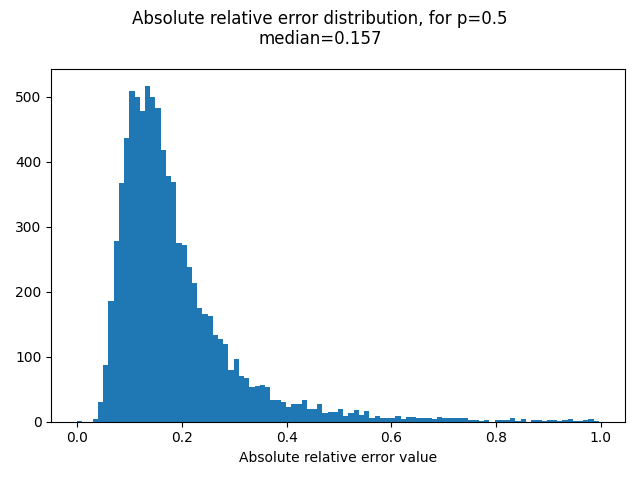

                  0
count  8.528000e+03
mean   1.886393e-01
std    1.189676e-01
min    7.401487e-17
25%    1.139519e-01
50%    1.572068e-01
75%    2.222750e-01
max    9.963261e-01


In [112]:
p=0.5
abs_err = test_idw_whole(data, sensors, p=p)
abs_err = abs_err[abs_err <= 1]
fig = plt.figure()
plt.hist(abs_err, bins=100)
median = np.median(abs_err)
fig.suptitle(f'Absolute relative error distribution, for p={p}\nmedian={nstr(mpf(median), 3)}')
plt.xlabel('Absolute relative error value')
fig.tight_layout()
plt.show()
print(pd.DataFrame(abs_err).describe())

## Conclusion

IDW method for $p=0.5$ has median absolute relative error equals $15.7\%$. Model is based only on 57 sensors and one parameter *pm10* (which haven't been filtered and shouldn't be fully trusted).


Under these conditions, this order of error is acceptable and can predict other values in a non-worst way. 